In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import scipy.sparse as sp
from Bio.PDB import *
from matplotlib import pyplot as plt
from mendeleev import element as ele

In [4]:
AMINO_ACIDS = np.array(['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG'
               , 'SER','THR', 'VAL', 'TRP', 'TYR'])

In [5]:
class PCM:    
    def __init__(self, p, path):
        self.p = p
        self.path = path
    
    #Find center of mass for side chains
    @staticmethod
    def getSideComCoord(residue):
        if residue.get_resname() == 'GLY':
            return residue['CA'].get_coord()
        else:
            temp = np.array([0., 0., 0.])
            sc = 0

            sc_flag = False
            for atom in residue:
                if atom.get_id() != 'CB' and not sc_flag:
                    continue

                sc_flag = True
                temp += atom.get_coord()
                sc += 1
                
        return temp/sc 
        
        
    """First version of contact map, unweight and undirected"""
    def getContactMap1(self):
        parser = PDBParser()
        structure = parser.get_structure(self.p, self.path)[0]

        res_list = []

        p_chains = []
        for chain in structure:
            for residue in chain:
                if residue.get_resname() in AMINO_ACIDS:
                    p_chains.append(chain)
                    break

        c_map = []
        for chain in p_chains:
            for residue in chain:
                if residue.get_resname() not in AMINO_ACIDS: 
                    continue

                res_list.append(residue.get_resname())

                temp = [] 
                counter = 0
                for c in p_chains:
                    for r in c:
                        if r.get_resname() not in AMINO_ACIDS: 
                            continue
                        counter += 1
                        dis = np.linalg.norm(residue['CA'].get_coord() - r['CA'].get_coord())
                        if dis <= 7:
                            temp.append(1)
                        else:
                            temp.append(0)
                c_map.append(temp)


        return c_map, res_list
    
    #Three different criterions, unweighted and undirected
    def getContactMap2(self):
        parser = PDBParser()
        structure = parser.get_structure(self.p, self.path)[0]

        res_list = []

        p_chains = []
        for chain in structure:
            for residue in chain:
                if residue.get_resname() in AMINO_ACIDS:
                    p_chains.append(chain)
                    break

        c_map = []
        for chain in p_chains:
            for residue in chain:
                if residue.get_resname() not in AMINO_ACIDS: 
                    continue

                res_list.append(residue.get_resname())

                temp = [] 
                counter = 0
                for c in p_chains:
                    for r in c:
                        if r.get_resname() not in AMINO_ACIDS: 
                            continue
                        counter += 1
                        #Carbon alpha distance
                        dis_alpha = np.linalg.norm(residue['CA'].get_coord() - r['CA'].get_coord())
                        
                        #Carbon beta distance, if the residue is Glycine, carbon alpha is used
                        if residue.get_resname() == 'GLY' and r.get_resname() != 'GLY': 
                            dis_beta = np.linalg.norm(residue['CA'].get_coord() - r['CB'].get_coord())
                        elif residue.get_resname() != 'GLY' and r.get_resname() == 'GLY':
                            dis_beta = np.linalg.norm(residue['CB'].get_coord() - r['CA'].get_coord())
                        elif residue.get_resname() == 'GLY' and r.get_resname() == 'GLY':
                            dis_beta = np.linalg.norm(residue['CA'].get_coord() - r['CA'].get_coord())
                        elif residue.get_resname() != 'GLY' and r.get_resname() != 'GLY':
                            dis_beta = np.linalg.norm(residue['CB'].get_coord() - r['CB'].get_coord())
                        
                        #Side chain distance
                        #dis_sc = 10
                        dis_sc = np.linalg.norm(self.getSideComCoord(residue) - self.getSideComCoord(r))
                        
                        if dis_alpha <= 7 or dis_beta <= 7 or dis_sc <= 7:
                            temp.append(1)
                        else:
                            temp.append(0)
                c_map.append(temp)
                
        return c_map, res_list
    
    #Three different criterions, weighted and undirected
    def getContactMap3(self):
        parser = PDBParser()
        structure = parser.get_structure(self.p, self.path)[0]

        res_list = []

        p_chains = []
        for chain in structure:
            for residue in chain:
                if residue.get_resname() in AMINO_ACIDS:
                    p_chains.append(chain)
                    break

        c_map = []
        for chain in p_chains:
            for residue in chain:
                if residue.get_resname() not in AMINO_ACIDS: 
                    continue

                res_list.append(residue.get_resname())

                temp = [] 
                counter = 0
                for c in p_chains:
                    for r in c:
                        if r.get_resname() not in AMINO_ACIDS: 
                            continue
                        counter += 1
                        #Carbon alpha distance
                        dis_alpha = np.linalg.norm(residue['CA'].get_coord() - r['CA'].get_coord())
                        
                        #Carbon beta distance, if the residue is Glycine, carbon alpha is used
                        if residue.get_resname() == 'GLY' and r.get_resname() != 'GLY': 
                            dis_beta = np.linalg.norm(residue['CA'].get_coord() - r['CB'].get_coord())
                        elif residue.get_resname() != 'GLY' and r.get_resname() == 'GLY':
                            dis_beta = np.linalg.norm(residue['CB'].get_coord() - r['CA'].get_coord())
                        elif residue.get_resname() == 'GLY' and r.get_resname() == 'GLY':
                            dis_beta = np.linalg.norm(residue['CA'].get_coord() - r['CA'].get_coord())
                        elif residue.get_resname() != 'GLY' and r.get_resname() != 'GLY':
                            dis_beta = np.linalg.norm(residue['CB'].get_coord() - r['CB'].get_coord())
                        
                        #Side chain distance
                        #dis_sc = 10
                        dis_sc = np.linalg.norm(self.getSideComCoord(residue) - self.getSideComCoord(r))
                        
                        """Set the weight to the closest link, could be changed later"""
                        if dis_alpha <= 7 or dis_beta <= 7 or dis_sc <= 7:
                            temp.append(7 - min(dis_alpha, dis_beta, dis_sc))
                        else:
                            temp.append(0)
                c_map.append(temp)
                
        return c_map, res_list
    
    #Three different criterions, weighted and undirected
    def getContactMap4(self):
        parser = PDBParser()
        structure = parser.get_structure(self.p, self.path)[0]

        res_list = []

        p_chains = []
        for chain in structure:
            for residue in chain:
                if residue.get_resname() in AMINO_ACIDS:
                    p_chains.append(chain)
                    break

        c_map = []
        for chain in p_chains:
            for residue in chain:
                if residue.get_resname() not in AMINO_ACIDS: 
                    continue

                res_list.append(residue.get_resname())

                temp = [] 
                counter = 0
                for c in p_chains:
                    for r in c:
                        if r.get_resname() not in AMINO_ACIDS: 
                            continue
                        counter += 1
                        #Carbon alpha distance
                        dis_alpha = np.linalg.norm(residue['CA'].get_coord() - r['CA'].get_coord())
                        
                        #Carbon beta distance, if the residue is Glycine, carbon alpha is used
                        if residue.get_resname() == 'GLY' and r.get_resname() != 'GLY': 
                            dis_beta = np.linalg.norm(residue['CA'].get_coord() - r['CB'].get_coord())
                        elif residue.get_resname() != 'GLY' and r.get_resname() == 'GLY':
                            dis_beta = np.linalg.norm(residue['CB'].get_coord() - r['CA'].get_coord())
                        elif residue.get_resname() == 'GLY' and r.get_resname() == 'GLY':
                            dis_beta = np.linalg.norm(residue['CA'].get_coord() - r['CA'].get_coord())
                        elif residue.get_resname() != 'GLY' and r.get_resname() != 'GLY':
                            dis_beta = np.linalg.norm(residue['CB'].get_coord() - r['CB'].get_coord())
                        
                        #Side chain distance
                        #dis_sc = 10
                        dis_sc = np.linalg.norm(self.getSideComCoord(residue) - self.getSideComCoord(r))
                        
                        """Set the weight to the closest link, could be changed later"""
                        if dis_alpha <= 7 or dis_beta <= 7 or dis_sc <= 7:
                            temp.append(7 - min(dis_alpha, dis_beta, dis_sc)) 
                        else:
                            temp.append(0)
                        """If the bond is polypeptide bond, double the score, this can be change"""
                        if chain == c and abs(residue.get_id()[1] - r.get_id()[1]) == 1:
#                             print(True)
                            temp[-1] = temp[-1] * 2
                            
                c_map.append(temp)
                
        return c_map, res_list

In [6]:
pcm = PCM('2BU1', '../datasets/Tongji/benchmark/pdb/2BU1.pdb')

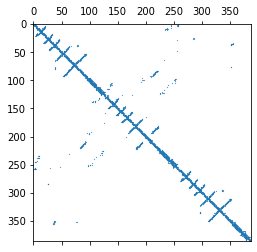

In [7]:
contact_map_1, res_list_1 = pcm.getContactMap1()
adj_1 = sp.coo_matrix(contact_map_1, dtype = 'int')
plt.spy(adj_1, markersize = 0.2)

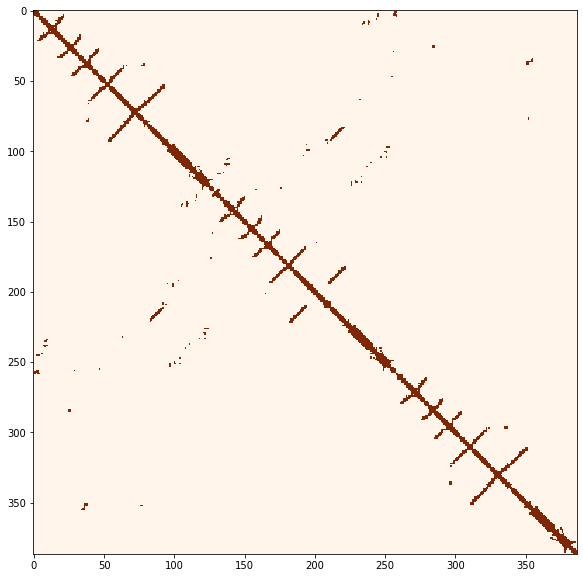

In [8]:
plt.figure(figsize = (10,10))
plt.imshow(contact_map_1, cmap = plt.cm.Oranges)

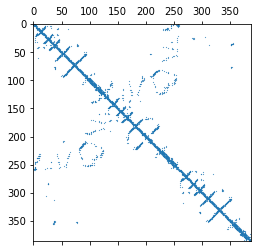

In [9]:
contact_map_2, res_list_2 = pcm.getContactMap2()
adj_2 = sp.coo_matrix(contact_map_2, dtype = 'int')
plt.spy(adj_2, markersize = 0.2)

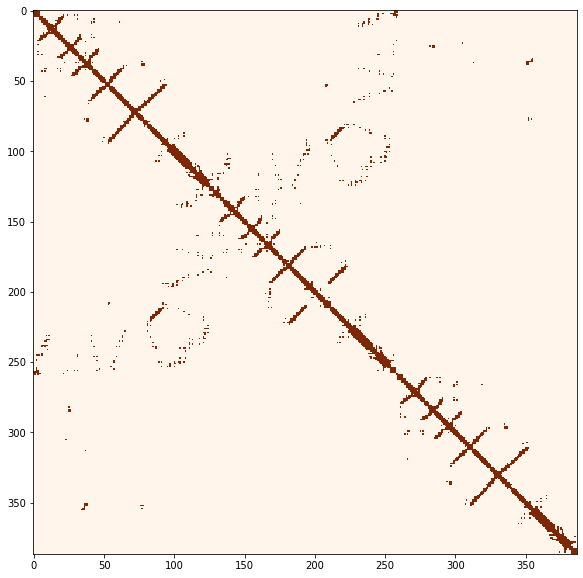

In [16]:
fig = plt.figure(figsize = (10, 10))
plt.imshow(contact_map_2, cmap = plt.cm.Oranges)

In [11]:
contact_map_3, res_list_3 = pcm.getContactMap3()
adj_3 = sp.coo_matrix(contact_map_3, dtype = 'int')
print(adj_3)

  (0, 0)	7
  (0, 1)	3
  (0, 2)	0
  (0, 257)	0
  (1, 0)	3
  (1, 1)	7
  (1, 2)	3
  (1, 3)	1
  (1, 4)	0
  (1, 257)	1
  (1, 258)	0
  (1, 259)	0
  (2, 0)	0
  (2, 1)	3
  (2, 2)	7
  (2, 3)	3
  (2, 4)	1
  (2, 245)	1
  (2, 248)	1
  (2, 249)	2
  (2, 254)	0
  (2, 255)	0
  (2, 256)	2
  (2, 257)	2
  (3, 1)	1
  :	:
  (382, 382)	7
  (382, 383)	3
  (383, 378)	2
  (383, 379)	1
  (383, 381)	2
  (383, 382)	3
  (383, 383)	7
  (383, 384)	3
  (383, 385)	0
  (383, 386)	0
  (384, 378)	2
  (384, 383)	3
  (384, 384)	7
  (384, 385)	3
  (384, 386)	0
  (385, 374)	0
  (385, 378)	1
  (385, 383)	0
  (385, 384)	3
  (385, 385)	7
  (385, 386)	3
  (386, 383)	0
  (386, 384)	0
  (386, 385)	3
  (386, 386)	7


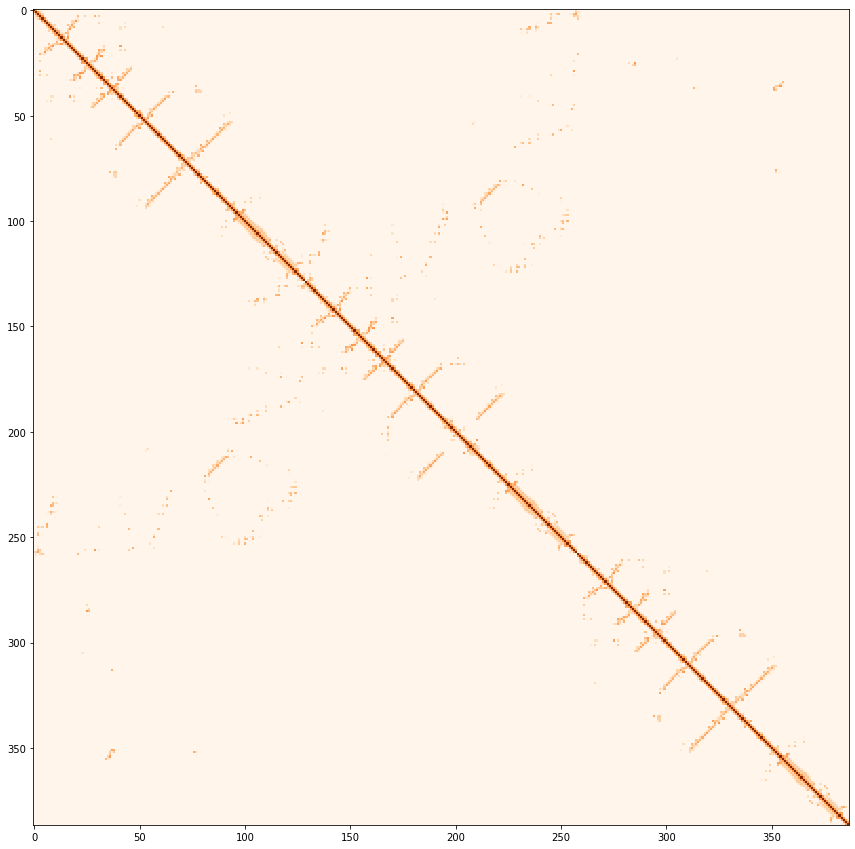

In [17]:
plt.figure(figsize = (15, 15))
plt.imshow(contact_map_3, cmap = plt.cm.Oranges, interpolation='nearest')

In [13]:
contact_map_4, res_list_4 = pcm.getContactMap4()
adj_4 = sp.coo_matrix(contact_map_4, dtype = 'int')
print(adj_4)

  (0, 0)	7
  (0, 1)	6
  (0, 2)	0
  (0, 257)	0
  (1, 0)	6
  (1, 1)	7
  (1, 2)	6
  (1, 3)	1
  (1, 4)	0
  (1, 257)	1
  (1, 258)	0
  (1, 259)	0
  (2, 0)	0
  (2, 1)	6
  (2, 2)	7
  (2, 3)	6
  (2, 4)	1
  (2, 245)	1
  (2, 248)	1
  (2, 249)	2
  (2, 254)	0
  (2, 255)	0
  (2, 256)	2
  (2, 257)	2
  (3, 1)	1
  :	:
  (382, 382)	7
  (382, 383)	6
  (383, 378)	2
  (383, 379)	1
  (383, 381)	2
  (383, 382)	6
  (383, 383)	7
  (383, 384)	6
  (383, 385)	0
  (383, 386)	0
  (384, 378)	2
  (384, 383)	6
  (384, 384)	7
  (384, 385)	6
  (384, 386)	0
  (385, 374)	0
  (385, 378)	1
  (385, 383)	0
  (385, 384)	6
  (385, 385)	7
  (385, 386)	6
  (386, 383)	0
  (386, 384)	0
  (386, 385)	6
  (386, 386)	7


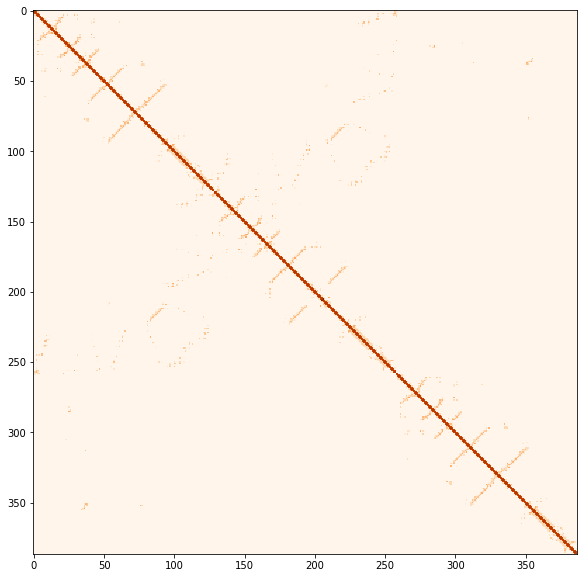

In [14]:
plt.figure(figsize = (10, 10))
plt.imshow(contact_map_4, cmap = plt.cm.Oranges, interpolation = 'nearest')

In [15]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, shape=<deprecated parameter>, filternorm=1, filterrad=4.0, imlim=<deprecated parameter>, resample=None, url=None, *, data=None, **kwargs)
    Display an image, i.e. data on a 2D regular raster.
    
    Parameters
    ----------
    X : array-like or PIL image
        The image data. Supported array shapes are:
    
        - (M, N): an image with scalar data. The data is visualized
          using a colormap.
        - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
        - (M, N, 4): an image with RGBA values (0-1 float or 0-255 int),
          i.e. including transparency.
    
        The first two dimensions (M, N) define the rows and columns of
        the image.
    
        Out-of-range RGB(A) values are clipped.
    
    cmap : str or `~matplotlib.colors.Colormap`, optional
        The 